In [1]:
import csv
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import re

# This notebook demonstrates taxonomic calculations for DUF4176s


In [2]:
odf = pd.read_excel('input_files/uniprotkb_DUF4176_2023_07_25.xlsx')

print(f'Full Dataset:\n{len(odf)}\n')

# remove fragments
udf = odf[odf['Fragment'] != 'fragment']
print(f'Not fragment Dataset:\n{len(udf)}\n')

# make taxonomic lineage usable
taxonomic_ranks = udf['Taxonomic lineage'].str.split(', ', expand=True)
taxonomic_ranks.drop(columns=[0,9,10], inplace=True)
taxonomic_ranks.columns = ['kingdom', 'clade', 'phylum', 'class', 'order', 'family', 'genus', 'species']
regex_v = r'\s*\([^)]*\)'
taxonomic_ranks = taxonomic_ranks.apply(lambda x: x.str.replace(regex_v, ''))
udf = pd.concat([udf, taxonomic_ranks], axis=1)


udf = udf.dropna(subset=['order', 'family', 'genus'],how='any')

print(f'No unkown taxons:\n{len(udf)}\n')
# bacteria data  only
bdf = udf[udf['kingdom'] == 'Bacteria']
print(f'Bacteria only:\n{len(bdf)}\n')
print(f'Percent Left unfiltered: {len(bdf)/len(odf)*100} \n')

not_caution = bdf[bdf['Caution'].isna()]
print(f'Percent not caution: {len(not_caution)/len(bdf)*100}')
print(f"Percent caution {100 - (len(not_caution)/len(bdf)*100)}")

# write bdf out to csv
bdf.to_csv('input_files/duf4176_bacteria_uniprot.csv', index=False)

# # Write out accessions with no caution -> see if alignments are better 
# not_caution['Entry'].to_csv('phylo_export/duf4176_bacteria_not_caution.txt', index=False, header=False)

/Users/dirk/miniconda3/envs/af2_tools/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Full Dataset:
2399

Not fragment Dataset:
2355

No unkown taxons:
2270

Bacteria only:
2265

Percent Left unfiltered: 94.41433930804502 

Percent not caution: 26.93156732891832
Percent caution 73.06843267108168


/var/folders/8v/vvcy5rtx1pd33q_5wmhd058w0000gn/T/ipykernel_51416/3899664725.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  taxonomic_ranks = taxonomic_ranks.apply(lambda x: x.str.replace(regex_v, ''))


# Basic Phylogenetic Info

## Examine whole dataset

In [3]:
def print_counts(df, column):
    counts = df[f'{column}'].value_counts()
    percentages = df[f'{column}'].value_counts(normalize=True)

    result = pd.concat([counts, percentages * 100], axis=1, keys=['Counts', 'Percentages'])
    print(f'\n{column} counts and percentages:\n{result}')
    return 

phylo_ranks = ['kingdom', 'clade', 'phylum']
for rank in phylo_ranks:
    print_counts(bdf, rank)



kingdom counts and percentages:
          Counts  Percentages
Bacteria    2265        100.0

clade counts and percentages:
                     Counts  Percentages
Terrabacteria group    2230    98.454746
FCB group                17     0.750552
Pseudomonadota           15     0.662252
Fusobacteriota            3     0.132450

phylum counts and percentages:
                                       Counts  Percentages
Bacillota                                2155    95.143488
Actinomycetota                             70     3.090508
Bacteroidetes/Chlorobi group               15     0.662252
Gammaproteobacteria                        12     0.529801
Fusobacteriia                               3     0.132450
Mycoplasmatota                              3     0.132450
Alphaproteobacteria                         2     0.088300
Fibrobacterota                              2     0.088300
Deinococcota                                1     0.044150
Betaproteobacteria                          1    

## Filter and Examine Firmicutes (Bacillota)

In [4]:
fdf = udf[udf['phylum'] == 'Bacillota']
fdf['phylum'] = fdf['phylum'].replace('Bacillota', 'Firmicutes')


phylo_ranks = ['phylum', 'class', 'order', 'family', 'genus']
for rank in phylo_ranks:
    print_counts(fdf, rank)


phylum counts and percentages:
            Counts  Percentages
Firmicutes    2155        100.0

class counts and percentages:
                  Counts  Percentages
Bacilli             1715    79.582367
Clostridia           382    17.726218
Erysipelotrichia      44     2.041763
Negativicutes         11     0.510441
Tissierellia           3     0.139211

order counts and percentages:
                             Counts  Percentages
Bacillales                      867    40.232019
Lactobacillales                 848    39.350348
Eubacteriales                   372    17.262181
Erysipelotrichales               44     2.041763
Thermoanaerobacterales           10     0.464037
Veillonellales                    7     0.324826
Selenomonadales                   4     0.185615
Tissierellales                    2     0.092807
Tissierellia incertae sedis       1     0.046404

family counts and percentages:
                                                   Counts  Percentages
Streptococcaceae     

/var/folders/8v/vvcy5rtx1pd33q_5wmhd058w0000gn/T/ipykernel_51416/844648954.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdf['phylum'] = fdf['phylum'].replace('Bacillota', 'Firmicutes')


In [5]:
# Make a histogram of the sequence lengths

def make_histo_groups(df, column, bin_width=6):
    # calculate the bin edges based on the maximum and minimum values of the data and the desired bin width
    min_seq_len = df[column].min()
    max_seq_len = df[column].max()
    bins = np.arange(min_seq_len, max_seq_len + bin_width, bin_width)
    print(f'Min: {min_seq_len} Max: {max_seq_len}')
    
    fig, ax =  plt.subplots(figsize=(3, 4))
    df.hist(column=column, bins=bins, color='red', alpha=0.8, ax=ax)
    
    ax.set_title(f'{column} - {len(df)} sequences')
    ax.set_xlabel('Sequence Length')
    ax.set_ylabel('Frequency')
    ax.set_xlim(0, max_seq_len)
    ax.set_xticks([0, 125, 250])
    ax.set_yticks(np.linspace(0, ax.get_ylim()[1], 3))
    ax.grid(False)  # turn off the grid lines
    plt.tight_layout()
    # plt.savefig(f'plots_histograms/frequency_cluster_{name}.svg')
    plt.show()
    return

 

In [6]:
n_fdf = fdf

n_fdf['big'] = n_fdf['Length'] > 195
n_fdf['small'] = n_fdf['Length'] < 130
print(f'Total big - {sum(n_fdf["big"])}')
print(f'Total small - {sum(n_fdf["small"])}')

big_fdf = n_fdf[n_fdf['big'] == True]
print(big_fdf['order'].value_counts(normalize=True))


top_orders = ['Lactobacillales', 'Bacillales', 'Eubacteriales']

top_orders_df = n_fdf[n_fdf['order'].isin(top_orders)]
for order in top_orders:
    small_ones = sum(top_orders_df["small"][top_orders_df["order"] == order])
    big_ones = sum(top_orders_df["big"][top_orders_df["order"] == order])
    
    print(f'\nSmall ones for {order} - {small_ones}')
    print(f'Big ones for {order} - {big_ones}')
#     print(f'Percent big ones {order} - {(big_ones / (big_ones + small_ones)) * 100}%\n')




Total big - 279
Total small - 1763
Lactobacillales       0.620072
Eubacteriales         0.186380
Bacillales            0.154122
Veillonellales        0.021505
Selenomonadales       0.010753
Erysipelotrichales    0.007168
Name: order, dtype: float64

Small ones for Lactobacillales - 599
Big ones for Lactobacillales - 173

Small ones for Bacillales - 812
Big ones for Bacillales - 43

Small ones for Eubacteriales - 295
Big ones for Eubacteriales - 52


/var/folders/8v/vvcy5rtx1pd33q_5wmhd058w0000gn/T/ipykernel_51416/3762612402.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n_fdf['big'] = n_fdf['Length'] > 195
/var/folders/8v/vvcy5rtx1pd33q_5wmhd058w0000gn/T/ipykernel_51416/3762612402.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n_fdf['small'] = n_fdf['Length'] < 130


# Make sundburst Diagram

In [7]:
import plotly.express as px
import numpy as np
import seaborn as sns

# create a color palette based on the "family" column
# get a list of unique values in the "family" column
unique_families = fdf['family'].unique()
# set the color palette to use 3-digit RGB values

family_counts = fdf['family'].value_counts()
    
# # combine categories with an occurrence below 5% into a new category called "other"
# other_count = family_counts[family_counts < 0.05 * family_counts.sum()].sum()
# family_counts = family_counts[family_counts >= 0.05 * family_counts.sum()]
# family_counts['other'] = other_count

# combine categories with an occurrence below 5% into a new category called "other"
other_count = family_counts[family_counts < 0.03 * family_counts.sum()].sum()
family_counts = family_counts[family_counts >= 0.03 * family_counts.sum()]
family_counts['other'] = other_count
# create a pie chart for the current cluster using the colors from the "family_colors" dictionary

# create a list of colors based on the "colorblind" color palette
palette_list = sns.color_palette('colorblind', n_colors=len(family_counts.index), as_cmap=True)
palette_list = palette_list * (len(family_counts.index) // len(palette_list) + 1)

# create a dictionary that maps each unique family to a specific color in the "husl" color palette
family_colors = {family: palette_list[i] for i, family in enumerate(family_counts.index)}
family_colors['other'] = 'gray'


# create a list of colors based on the "husl" color palette
palette_list = sns.color_palette('colorblind', n_colors=len(family_counts), as_cmap=True)
palette_list = palette_list * (len(family_counts.index) // len(palette_list) + 1)

# create a dictionary that maps each unique family to a specific color in the "husl" color palette
family_colors = {family: palette_list[i] for i, family in enumerate(family_counts.index)}
# family_colors['other'] = 'gray'
path=['phylum', 'class', 'order', 'family', 'Organism']
fig = px.sunburst(fdf, path=path, 
                  values=fdf.index,
                  color='family',
                  color_discrete_map=family_colors,
                  branchvalues='total')
                  
                #   color_continuous_midpoint = 125)
                #   color_continuous_midpoint=np.average(fdf['seq_len'], weights=fdf.index))


# show the diagram
fig.show()
fig.write_image('sunburst/sunburst_new.svg', format='svg')

# Lengths Histogram

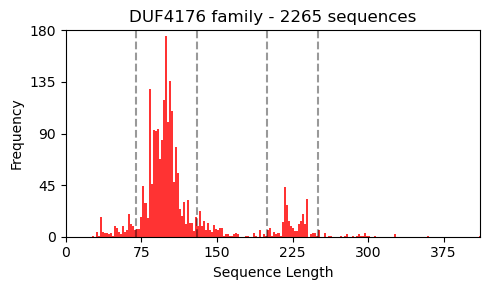

Number of sequences: 2265
 Minimum sequence length: 26
 Maximum sequence length: 411

Number of small sequences: 1707 - 75.36423841059603% of total
 Average length: 97.01523140011716
 Median length: 98.0

Number of big sequences: 257 - 11.346578366445916% of total
 Average length: 224.6770428015564
 Median length: 222.0


In [8]:
# calculate the bin edges based on the maximum and minimum values of the data and the desired bin width

# bdf=fdf
bin_width = 2
min_seq_len = bdf['Length'].min()
max_seq_len = bdf['Length'].max()
bins = np.arange(min_seq_len, max_seq_len + bin_width, bin_width)

# group the data by cluster_num


# plot a histogram for each group
fig, ax = plt.subplots(figsize=(5, 3))
bdf.hist(column='Length', bins=bins, color='red', alpha=0.8, ax=ax)

ax.set_title(f'DUF4176 family - {len(bdf)} sequences')
ax.set_xlabel('Sequence Length')
ax.set_ylabel('Frequency')
ax.set_xlim(0, max_seq_len)
ax.set_ylim(0, 180)
ax.set_xticks([0, 75, 150, 225, 300, 375])
ax.set_yticks(np.linspace(0, ax.get_ylim()[1], 5).astype(int))
ax.grid(False)  # turn off the grid lines

# add vertical dotted lines
ax.axvline(x=70, color='black', linestyle='--', alpha=0.4)
ax.axvline(x=130, color='black', linestyle='--', alpha=0.4)
ax.axvline(x=200, color='black', linestyle='--', alpha=0.4)
ax.axvline(x=250, color='black', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.savefig(f'plots_histograms/Whole_DUF4176_Frequency.svg')
plt.show()

print(f'Number of sequences: {len(bdf)}\n Minimum sequence length: {min_seq_len}\n Maximum sequence length: {max_seq_len}')

# small_duf = bdf.loc[bdf['Length'] < 125 & bdf['Length'] > 75]
small_duf = bdf.loc[(bdf['Length'] < 130) & (bdf['Length'] > 70)]
big_duf = bdf.loc[(bdf['Length'] > 195) & (bdf['Length'] < 255)]

print(f'\nNumber of small sequences: {len(small_duf)} - {len(small_duf)/len(bdf)*100}% of total\n Average length: {np.average(small_duf["Length"])}\n Median length: {np.median(small_duf["Length"])}')

print(f'\nNumber of big sequences: {len(big_duf)} - {len(big_duf)/len(bdf)*100}% of total\n Average length: {np.average(big_duf["Length"])}\n Median length: {np.median(big_duf["Length"])}')


# Extract info for the accessions of interest 
 Select ~3 operons for 5 clusters (1-4,6) manually
	- Mark as "of interest" via new column on big accession dataframe 
	- run genbank retrieval -> switch to CDS
	- Create ~50 sequence alignments by cluster with accessions of interest assured to be within the list. 

In [9]:
clusters = [x for x in range(1, 5)] + [6]
int_acc_df = pd.read_csv('input_files/accs_of_interest.csv')

sel_df = pd.merge(int_acc_df, bdf, left_on='accession', right_on='Entry', how='left')
sel_df = sel_df.rename(columns={'assigned_cluster': 'cluster_num'})

#to avoid changing downstream scirpt
accs_df = sel_df
accs_df['Gene Names'] = accs_df['Gene Names'].str.split(" ").str[0]

accs_df = accs_df.rename(columns={'Gene Names': 'gene_name'})
accs_df['EMBL'] = accs_df['EMBL'].str.split(";").str[0]



# EMBL retreival functions
- Need to create directory structure ./cluster/operon/genbanks
- Bring in code from embl notebook 
- adapt to directory structure

In [10]:
from Bio import Entrez
from Bio import SeqIO
import requests
import xml.etree.ElementTree as ET
import os
import subprocess
import glob
import pandas as pd

# Replace with your email address
Entrez.email = "dirkgrebenc@gmail.com"

# Function to fetch a region around a gene from the parent genome
def fetch_genomic_region(chr_accession, start, end, strand, bp_upstream=3500, bp_downstream=3500):
    if strand == "plus":
        start = start - bp_upstream
        end = end + bp_downstream
    else:
        start = start - bp_downstream
        end = end + bp_upstream

    handle = Entrez.efetch(db="nucleotide", id=chr_accession, rettype="gb", retmode="text", seq_start=start, seq_stop=end)
    record = SeqIO.read(handle, "gb")
    handle.close()

    return record


def fetch_gene_info(genbank_id, gene_name):

    try:
        handle = Entrez.efetch(db="nucleotide", id=genbank_id, rettype="gb", retmode="text")
        record = SeqIO.read(handle, "gb")
        handle.close()

        for feature in record.features:
            # print(feature.qualifiers)
            if feature.type == "gene" and 'locus_tag' in feature.qualifiers:
                if gene_name in feature.qualifiers['locus_tag']:
                    chr_accession = record.id
                    gene_start = int(feature.location.start)
                    gene_end = int(feature.location.end)
                    gene_strand = 'plus' if feature.location.strand == 1 else 'minus'
                    return chr_accession, gene_start, gene_end, gene_strand
                else:
                    continue
            else:
                continue      
    except Exception as e:
        print(f"Error fetching gene info for GenBank ID {genbank_id}: {e}")
        return None, None, None, None

# Use the truncated df of genes of interest

clusters = [x for x in range(1, 5)] + [6]
for cluster in clusters:
    active_df = accs_df[accs_df['cluster_num'] == cluster]
    cluster_path = f'genbanks/cluster_{cluster}'
    os.makedirs(cluster_path, exist_ok=True)
    accs_triple = active_df[['gene_name', 'EMBL', 'accession']]
    accs_triple 

    for row, col in accs_triple.iterrows():
        print(f"Accession: {col[2]}, Gene Name: {col[0]}, EMBL: {col[1]}")    
        chr_accession, gene_start, gene_end, gene_strand = fetch_gene_info(col[1], col[0])
        print(f"Accession {chr_accession} \n GeneStart {gene_start} \n GeneStop {gene_end}" )
        gb_record = fetch_genomic_region(chr_accession, gene_start, gene_end, gene_strand)
        genbank_file_path = f'{cluster_path}/{col[2]}_region.gb'
        with open(genbank_file_path, "w") as output_file:
            SeqIO.write(gb_record, output_file, "gb")

Accession: A0A8B4ISZ8, Gene Name: NCTC3858_01460, EMBL: LS483397
Accession LS483397.1 
 GeneStart 1386170 
 GeneStop 1386461
Accession: A0A1X1JWW4, Gene Name: B7700_09675, EMBL: NCVF01000026
Accession NCVF01000026.1 
 GeneStart 219855 
 GeneStop 220167
Accession: T1ZCF9, Gene Name: SIR_0168, EMBL: CP003857
Accession CP003857.1 
 GeneStart 165187 
 GeneStop 165847
Accession: T1ZCG6, Gene Name: SIR_0178, EMBL: CP003857
Accession CP003857.1 
 GeneStart 179185 
 GeneStop 179899
Accession: A0A091BL67, Gene Name: H702_09920, EMBL: AUZH01000037
Accession AUZH01000037.1 
 GeneStart 3635 
 GeneStop 4331
Accession: A0A1E5KV91, Gene Name: BCR26_04510, EMBL: MIEK01000045
Accession MIEK01000045.1 
 GeneStart 102894 
 GeneStop 103290
Accession: A0A1H9B3K6, Gene Name: SAMN05216346_10286, EMBL: FOEX01000002
Accession FOEX01000002.1 
 GeneStart 86496 
 GeneStop 86793
Accession: A0A841YHN3, Gene Name: HB844_13120, EMBL: JAARPY010000018
Accession JAARPY010000018.1 
 GeneStart 5672 
 GeneStop 5987
Accessi

# Run clinker on cluster directories

In [11]:
def run_clinker(parent_directory, identity_threshold=0.2, delimiter="\t", decimals=4):
    # Run clinker with the specified options
    name = os.path.basename(parent_directory)
    plot_output = os.path.join(parent_directory, f"{name}_plot.html")
    output_file = os.path.join(parent_directory, f"{name}_alignments.tsv")

    subprocess.run(
        [
            "clinker",
            "-i",
            str(identity_threshold),
            "-o",
            output_file,
            "-dl",
            delimiter,
            "-dc",
            str(decimals),
            "-p",
            plot_output,
            parent_directory
        ]
    )
    return

import glob

cluster_paths = glob.glob('genbanks/cluster_*')
for path in cluster_paths:
    run_clinker(path)


[15:26:30] INFO - Starting clinker
[15:26:30] INFO - Parsing files:
[15:26:30] INFO -   C8NIU9_region.gb
[15:26:31] INFO -   E8K2X5_region.gb
/Users/dirk/miniconda3/envs/af2_tools/lib/python3.9/site-packages/Bio/Seq.py:2804: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
[15:26:31] INFO -   B4U1P1_region.gb
[15:26:31] INFO - Starting cluster alignments
[15:26:32] INFO - C8NIU9_region vs E8K2X5_region
[15:26:32] INFO - C8NIU9_region vs B4U1P1_region
[15:26:32] INFO - E8K2X5_region vs B4U1P1_region
[15:26:32] INFO - Generating results summary...
[15:26:32] INFO - Writing alignments to: genbanks/cluster_6/cluster_6_alignments.tsv
[15:26:32] INFO - Building clustermap.js visualisation
[15:26:32] INFO - Writing to: genbanks/cluster_6/cluster_6_plot.html
[15:26:32] INFO - Done!
[15:26:33] INFO - Starting clinker
[15:26:33] INFO - Parsing files:
[15: